### Importing Required Libraries

In [10]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Device Setup and Hyperparameters

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 0.0002
weight_decay = 5e-4 

Using device: cuda


### Custom Dataset Class : TsinghuaDogsDataset (Image and Label Loader)

In [12]:
class TsinghuaDogsDataset(Dataset):
    def __init__(self, image_root, annotation_root, transform=None):
        self.image_root = image_root
        self.annotation_root = annotation_root
        self.transform = transform
        
        # Getting all image paths
        self.image_paths = []
        self.labels = []
        self.classes = []
        
        # Parsing folder structure to get image paths and breed labels
        breed_folders = [f for f in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, f))]
        
        print(f"Found {len(breed_folders)} breed folders")
        
        for breed_idx, breed_folder in enumerate(sorted(breed_folders)):
            breed_path = os.path.join(image_root, breed_folder)
            
            # Extract breed name from folder
            if '-' in breed_folder:
                breed_name = breed_folder.split('-')[2]
            else:
                breed_name = breed_folder
                
            self.classes.append(breed_name)
            
            # Finding all images for this breed (including in subfolders)
            image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
            images = []
            
            # Walk through all subfolders
            for root, _, files in os.walk(breed_path):
                for file in files:
                    if any(file.lower().endswith(ext) for ext in image_extensions):
                        images.append(os.path.join(root, file))
            
            print(f"Breed {breed_name}: found {len(images)} images")
            
            for img_path in images:
                self.image_paths.append(img_path)
                self.labels.append(breed_idx)
        
        print(f"Total: {len(self.image_paths)} images across {len(self.classes)} dog breeds")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Data Augmentation

In [13]:
# Define data transforms with stronger augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Stronger color jitter
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # More distortion
    transforms.RandomGrayscale(p=0.15),  # Increased probability
    transforms.RandomPerspective(distortion_scale=0.3, p=0.6),  # Increased distortion and probability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2))  # Increased probability and scale
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Tsinghua Dogs Dataset Preparation and Splitting

In [14]:
# Data loading
image_dir = "/kaggle/input/tsinghua-dogs/low-resolution/low-resolution" 
annotation_dir = "/kaggle/input/tsinghua-dogs/low-annotations/Low-Annotations" 

# Creating dataset
full_dataset = TsinghuaDogsDataset(image_root=image_dir, annotation_root=annotation_dir, transform=train_transform)


Found 130 breed folders
Breed Shiba_Dog: found 1043 images
Breed French_bulldog: found 1121 images
Breed Siberian_husky: found 1160 images
Breed malamute: found 1324 images
Breed Pomeranian: found 1936 images
Breed Airedale: found 200 images
Breed miniature_poodle: found 200 images
Breed affenpinscher: found 200 images
Breed schipperke: found 201 images
Breed Australian_terrier: found 202 images
Breed Welsh_springer_spaniel: found 202 images
Breed curly_coated_retriever: found 202 images
Breed Staffordshire_bullterrier: found 203 images
Breed Norwich_terrier: found 203 images
Breed Tibetan_terrier: found 203 images
Breed English_setter: found 203 images
Breed Norfolk_terrier: found 203 images
Breed Pembroke: found 205 images
Breed Tibetan_mastiff: found 205 images
Breed Border_terrier: found 206 images
Breed Great_Dane: found 206 images
Breed Scotch_terrier: found 206 images
Breed flat_coated_retriever: found 206 images
Breed Saluki: found 206 images
Breed Irish_setter: found 207 image

### Calculating class distribution

Total classes: 130
Min class size: 200 (affenpinscher)
Max class size: 7449 (teddy)
Average class size: 541.8
Median class size: 225.0


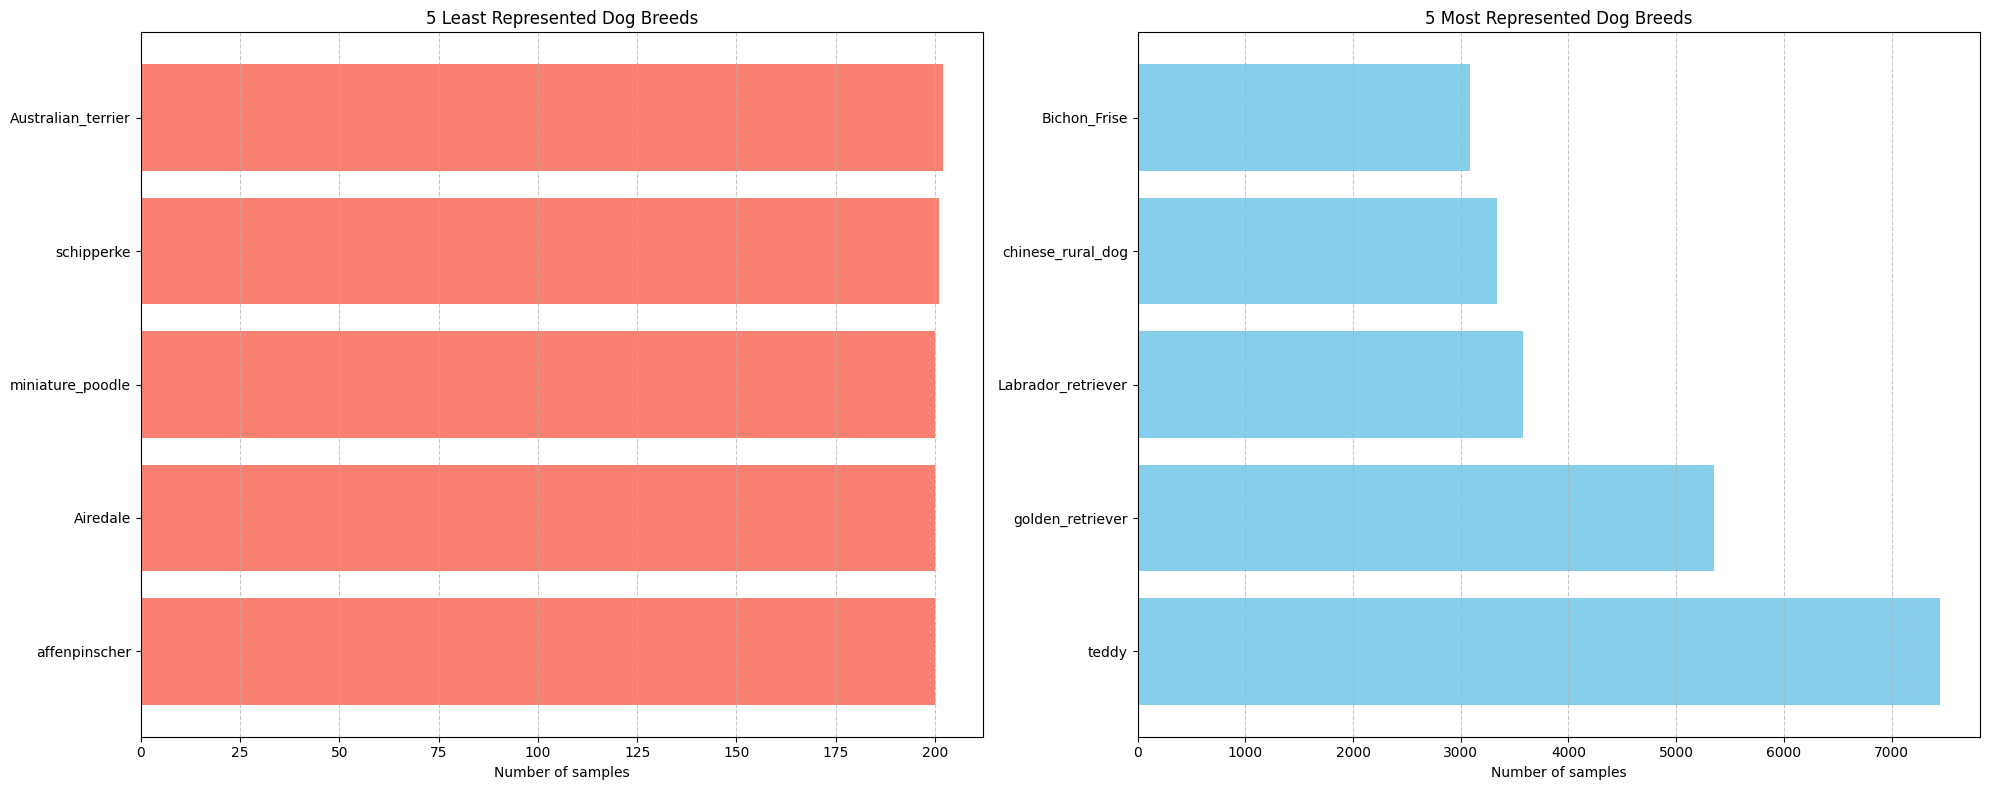

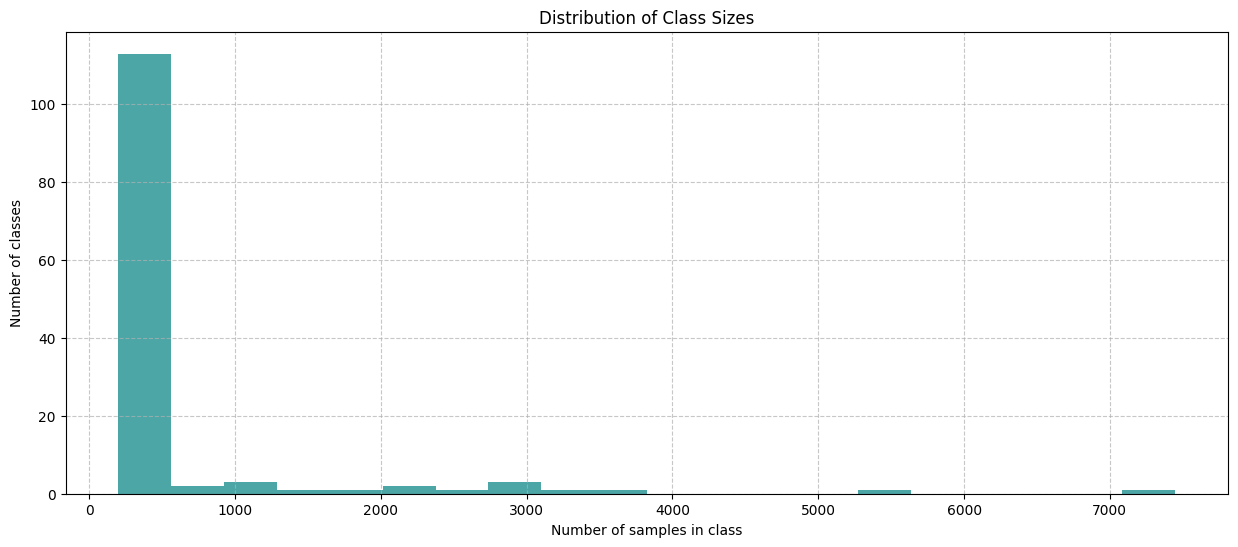

In [15]:
def analyze_class_imbalance(dataset):
    """Analyze and visualize class imbalance in the dataset"""
    # Count samples per class
    class_counts = {}
    for label in dataset.labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Convert to lists for plotting
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    class_names = [dataset.classes[i] for i in classes]
    
    # Create a DataFrame for easier handling
    import pandas as pd
    class_dist_df = pd.DataFrame({
        'class_idx': classes,
        'class_name': class_names,
        'count': counts
    })
    
    # Sort by count
    class_dist_df = class_dist_df.sort_values('count')
    
    # Print summary statistics
    print(f"Total classes: {len(class_dist_df)}")
    print(f"Min class size: {class_dist_df['count'].min()} ({class_dist_df.iloc[0]['class_name']})")
    print(f"Max class size: {class_dist_df['count'].max()} ({class_dist_df.iloc[-1]['class_name']})")
    print(f"Average class size: {class_dist_df['count'].mean():.1f}")
    print(f"Median class size: {class_dist_df['count'].median():.1f}")
    
    # Plot top 5 and bottom 5 classes
    plt.figure(figsize=(20, 8))
    
    # Bottom 5 classes
    plt.subplot(1, 2, 1)
    bottom5 = class_dist_df.head(5)
    plt.barh(bottom5['class_name'], bottom5['count'], color='salmon')
    plt.xlabel('Number of samples')
    plt.title('5 Least Represented Dog Breeds')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Top 5 classes
    plt.subplot(1, 2, 2)
    top5 = class_dist_df.tail(5).iloc[::-1]  # Reverse to show highest first
    plt.barh(top5['class_name'], top5['count'], color='skyblue')
    plt.xlabel('Number of samples')
    plt.title('5 Most Represented Dog Breeds')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return class_dist_df
# Call the analysis function
class_distribution = analyze_class_imbalance(full_dataset)

In [16]:
# 1. Weighted Random Sampler for the training set
def create_weighted_sampler(dataset):
    """Create a weighted sampler to balance classes during training"""
    # Count samples per class
    class_counts = {}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Calculate weights
    weights = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        # Weight is inverse of class frequency
        weights.append(1.0 / class_counts[label])
    
    # Create the sampler
    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(dataset),
        replacement=True
    )
    
    return sampler

In [17]:
num_classes = len(full_dataset.classes)

# 2. Class weights for the loss function
def calculate_class_weights(dataset):
    """Calculate class weights for weighted loss function"""
    # Count samples per class
    class_counts = {}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Calculate weights (inversely proportional to class frequency)
    weights = []
    total_samples = len(dataset)
    for i in range(num_classes):
        if i in class_counts and class_counts[i] > 0:
            weights.append(total_samples / (num_classes * class_counts[i]))
        else:
            weights.append(1.0)  # Default weight for empty classes
    
    # Convert to tensor
    class_weights = torch.FloatTensor(weights).to(device)
    return class_weights

# Update the loss function with class weights
class_weights = calculate_class_weights(full_dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights)

### Modify Data Augmentation for Minority Classes

def get_minority_classes(class_distribution, threshold=0.5):
    """Get classes with sample counts below the threshold percentile"""
    threshold_count = np.percentile(class_distribution['count'], threshold * 100)
    return class_distribution[class_distribution['count'] < threshold_count]['class_idx'].tolist()

minority_classes = get_minority_classes(class_distribution, threshold=0.3)  # Bottom 30%

class BalancedDataAugmentation:
    """Apply more aggressive augmentation to minority classes"""
    def __init__(self, minority_classes, base_transform, strong_transform):
        self.minority_classes = minority_classes
        self.base_transform = base_transform
        self.strong_transform = strong_transform
    
    def __call__(self, image, label):
        if label in self.minority_classes:
            # Apply stronger augmentation for minority classes
            return self.strong_transform(image)
        else:
            # Apply regular augmentation for majority classes
            return self.base_transform(image)

# Define stronger augmentation for minority classes
strong_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.8),  # Increased probability
    transforms.RandomRotation(45),  # Even more rotation
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),
    transforms.RandomAffine(degrees=30, translate=(0.3, 0.3), scale=(0.7, 1.3), shear=15),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))  # Increased probability and scale
])


###  Data Splitting into train and validation

In [18]:
# Splitting into train and validation sets (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply different transforms to each split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

### DataLoader Setup and Dataset Statistics

In [19]:
# Create data loaders
train_sampler = create_weighted_sampler(train_dataset)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=train_sampler,  # Use the weighted sampler
    num_workers=2, 
    pin_memory=True
)


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Get number of classes and print dataset information
num_classes = len(full_dataset.classes)
print(f"Total number of images: {len(full_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Total number of images: 70432
Number of classes: 130
Training set size: 56345
Validation set size: 14087


### Data Augmentation Visualization

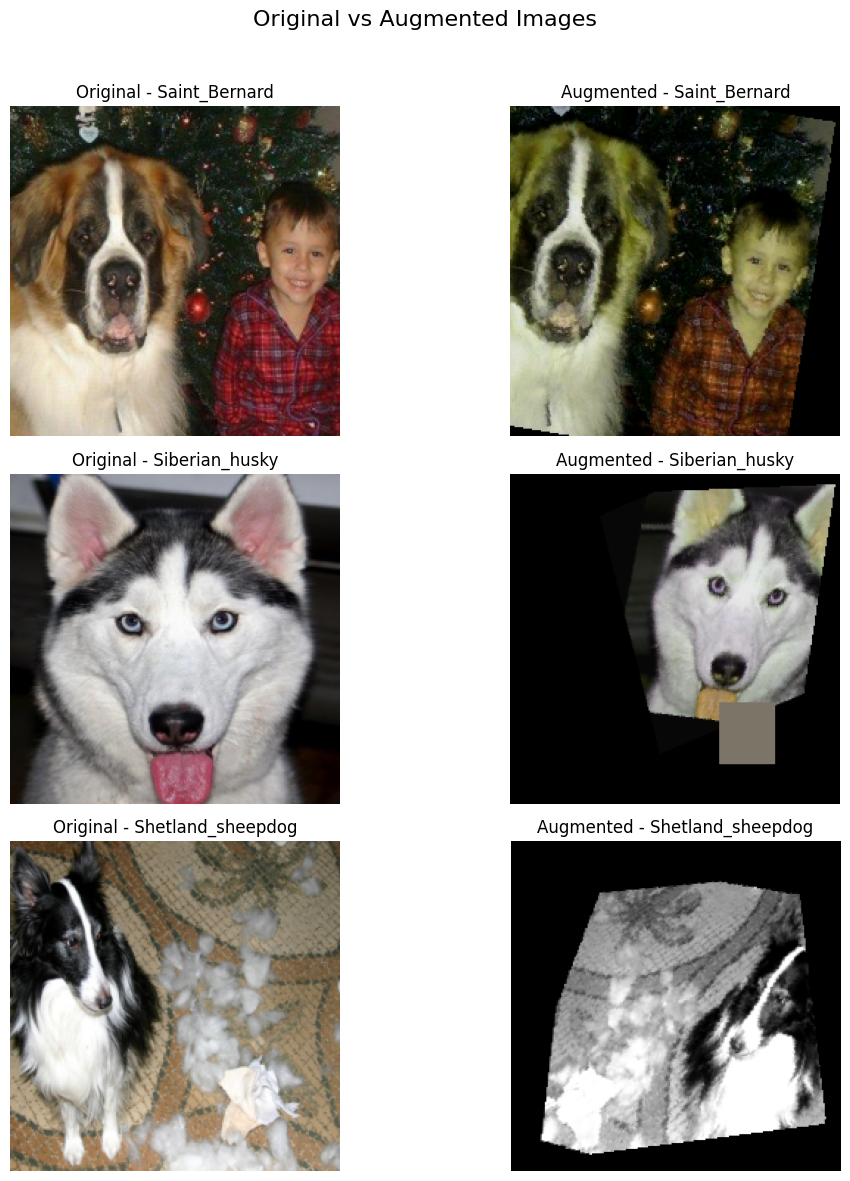

In [20]:
# Helper function to denormalize and convert tensor to numpy image
def tensor_to_image(tensor):
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    # Convert to numpy and transpose to (H,W,C) format
    img = tensor.numpy().transpose(1, 2, 0)
    # Clip values to ensure they're in valid range
    img = np.clip(img, 0, 1)
    return img

# Use the test_transform you already defined as the "basic" transform
# This avoids creating a redundant transform

# Select 3 random images to visualize
random.seed(42)  # For reproducible results
indices = random.sample(range(len(full_dataset)), 3)

# Plot the images
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.tight_layout()

for i, idx in enumerate(indices):
    # Get image path
    img_path = full_dataset.image_paths[idx]
    original_img = Image.open(img_path).convert('RGB')
    
    # Get breed name
    breed_idx = full_dataset.labels[idx]
    breed_name = full_dataset.classes[breed_idx]
    
    # Create basic version (without augmentation) 
    basic_tensor = test_transform(original_img)
    basic_image = tensor_to_image(basic_tensor)
    
    # Create augmented version
    augmented_tensor = train_transform(original_img)
    augmented_image = tensor_to_image(augmented_tensor)
    
    # Display images
    axs[i, 0].imshow(basic_image)
    axs[i, 0].set_title(f"Original - {breed_name}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(augmented_image)
    axs[i, 1].set_title(f"Augmented - {breed_name}")
    axs[i, 1].axis('off')

plt.suptitle("Original vs Augmented Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Custom ResidualBlock with Dropout (Resnet-Architecture Style)

In [21]:
# Defining the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

### ResNet-Based Model Architecture with Progressive Dropout

In [22]:
class DogBreedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(DogBreedCNN, self).__init__()
        self.dropout_rate = dropout_rate
        
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks with dropout
        self.layer1 = self._make_layer(64, 64, 2, dropout_rate=0.1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2, dropout_rate=0.15)
        self.layer3 = self._make_layer(128, 256, 2, stride=2, dropout_rate=0.2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2, dropout_rate=0.25)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1, dropout_rate=0.2):
        layers = []
        
        # First block with potential downsampling
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample, dropout_rate))
        
        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout_rate=dropout_rate))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Initializing the model
model = DogBreedCNN(num_classes, dropout_rate=0.6).to(device)

### Loss Function, Optimizer, and LR Scheduler Setup

In [23]:
# Setting up loss, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

### Mixup Data Augmentation

In [24]:
# Mixup data augmentation function
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training the Model with Mixup and Early Stopping


In [25]:
# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, 
                         mixup_alpha=0.2, patience=5, grad_accum_steps=1):
    best_val_acc = 0.0
    early_stop_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        optimizer.zero_grad()  # Zero gradients at the beginning of epoch
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Apply mixup
            inputs_mixed, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
            
            # Forward pass
            outputs = model(inputs_mixed)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
            # Scale loss by accumulation steps
            loss = loss / grad_accum_steps
            loss.backward()
            
            # Gradient accumulation
            if (batch_idx + 1) % grad_accum_steps == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            # Calculate statistics
            running_loss += loss.item() * inputs.size(0) * grad_accum_steps
            
            # Calculate accuracy on original inputs (not mixed)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item() * grad_accum_steps, "accuracy": 100 * correct / total})
        
        # Handle any remaining accumulated gradients
        if len(train_loader) % grad_accum_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item(), "accuracy": 100 * correct / total})
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Update learning rate scheduler
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_dog_breed_model.pth')
            print(f"Model saved with validation accuracy: {best_val_acc:.2f}%")
            early_stop_counter = 0  # Reset counter if improved
        else:
            early_stop_counter += 1
            print(f"No improvement for {early_stop_counter} epochs.")
        
        # Early stopping check
        if early_stop_counter >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

### Train the Model 

In [26]:
# Train the model with advanced techniques
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs,
    mixup_alpha=0.5, patience=7, grad_accum_steps=2
)

Epoch 1/50 [Val]: 100%|██████████| 441/441 [00:46<00:00,  9.47it/s, loss=3.61, accuracy=7.96]


Epoch 1/50
Train Loss: 4.6278 Train Acc: 3.67%
Val Loss: 3.9599 Val Acc: 7.96%
Learning Rate: 0.000200
Model saved with validation accuracy: 7.96%


Epoch 2/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.74it/s, loss=3.57, accuracy=10.1]


Epoch 2/50
Train Loss: 4.2991 Train Acc: 7.92%
Val Loss: 3.8676 Val Acc: 10.05%
Learning Rate: 0.000199
Model saved with validation accuracy: 10.05%


Epoch 3/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.09it/s, loss=3.12, accuracy=18.6]


Epoch 3/50
Train Loss: 4.0857 Train Acc: 12.11%
Val Loss: 3.3807 Val Acc: 18.65%
Learning Rate: 0.000198
Model saved with validation accuracy: 18.65%


Epoch 4/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.80it/s, loss=3.18, accuracy=22.3]


Epoch 4/50
Train Loss: 3.9299 Train Acc: 15.88%
Val Loss: 3.3045 Val Acc: 22.28%
Learning Rate: 0.000197
Model saved with validation accuracy: 22.28%


Epoch 5/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.17it/s, loss=2.65, accuracy=27.3]


Epoch 5/50
Train Loss: 3.8061 Train Acc: 19.48%
Val Loss: 3.0028 Val Acc: 27.28%
Learning Rate: 0.000195
Model saved with validation accuracy: 27.28%


Epoch 6/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.75it/s, loss=2.43, accuracy=30.7]


Epoch 6/50
Train Loss: 3.6381 Train Acc: 23.73%
Val Loss: 2.7694 Val Acc: 30.68%
Learning Rate: 0.000193
Model saved with validation accuracy: 30.68%


Epoch 7/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.95it/s, loss=2.49, accuracy=31.9]


Epoch 7/50
Train Loss: 3.5203 Train Acc: 28.02%
Val Loss: 2.7539 Val Acc: 31.92%
Learning Rate: 0.000191
Model saved with validation accuracy: 31.92%


Epoch 8/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.04it/s, loss=2.03, accuracy=31.9]


Epoch 8/50
Train Loss: 3.3927 Train Acc: 31.79%
Val Loss: 2.5871 Val Acc: 31.89%
Learning Rate: 0.000188
No improvement for 1 epochs.


Epoch 9/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.31it/s, loss=2.17, accuracy=37.7]


Epoch 9/50
Train Loss: 3.2930 Train Acc: 35.66%
Val Loss: 2.5006 Val Acc: 37.72%
Learning Rate: 0.000185
Model saved with validation accuracy: 37.72%


Epoch 10/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.17it/s, loss=2.14, accuracy=38.7]


Epoch 10/50
Train Loss: 3.1770 Train Acc: 39.38%
Val Loss: 2.4038 Val Acc: 38.74%
Learning Rate: 0.000181
Model saved with validation accuracy: 38.74%


Epoch 11/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.03it/s, loss=1.94, accuracy=39.8]


Epoch 11/50
Train Loss: 3.0991 Train Acc: 42.37%
Val Loss: 2.2862 Val Acc: 39.77%
Learning Rate: 0.000177
Model saved with validation accuracy: 39.77%


Epoch 12/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.10it/s, loss=1.88, accuracy=38.3]


Epoch 12/50
Train Loss: 3.0186 Train Acc: 45.74%
Val Loss: 2.2213 Val Acc: 38.29%
Learning Rate: 0.000173
No improvement for 1 epochs.


Epoch 13/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 11.00it/s, loss=1.89, accuracy=41.2]


Epoch 13/50
Train Loss: 2.9150 Train Acc: 49.22%
Val Loss: 2.2390 Val Acc: 41.15%
Learning Rate: 0.000169
Model saved with validation accuracy: 41.15%


Epoch 14/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.06it/s, loss=1.74, accuracy=45.4]


Epoch 14/50
Train Loss: 2.8478 Train Acc: 52.87%
Val Loss: 2.0915 Val Acc: 45.42%
Learning Rate: 0.000164
Model saved with validation accuracy: 45.42%


Epoch 15/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.94it/s, loss=1.76, accuracy=45.2]


Epoch 15/50
Train Loss: 2.7677 Train Acc: 56.13%
Val Loss: 2.0754 Val Acc: 45.19%
Learning Rate: 0.000159
No improvement for 1 epochs.


Epoch 16/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.90it/s, loss=1.74, accuracy=45.5]


Epoch 16/50
Train Loss: 2.7104 Train Acc: 59.27%
Val Loss: 2.1028 Val Acc: 45.47%
Learning Rate: 0.000154
Model saved with validation accuracy: 45.47%


Epoch 17/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.93it/s, loss=1.87, accuracy=45]  


Epoch 17/50
Train Loss: 2.6021 Train Acc: 62.33%
Val Loss: 2.0269 Val Acc: 45.01%
Learning Rate: 0.000148
No improvement for 1 epochs.


Epoch 18/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.06it/s, loss=1.61, accuracy=46.1]


Epoch 18/50
Train Loss: 2.5276 Train Acc: 65.66%
Val Loss: 2.0034 Val Acc: 46.06%
Learning Rate: 0.000143
Model saved with validation accuracy: 46.06%


Epoch 19/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.98it/s, loss=1.47, accuracy=49.2]


Epoch 19/50
Train Loss: 2.4239 Train Acc: 68.59%
Val Loss: 1.8912 Val Acc: 49.15%
Learning Rate: 0.000137
Model saved with validation accuracy: 49.15%


Epoch 20/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.95it/s, loss=1.52, accuracy=47.3]


Epoch 20/50
Train Loss: 2.3978 Train Acc: 71.50%
Val Loss: 1.9701 Val Acc: 47.34%
Learning Rate: 0.000131
No improvement for 1 epochs.


Epoch 21/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.79it/s, loss=1.35, accuracy=48.3]


Epoch 21/50
Train Loss: 2.3385 Train Acc: 74.12%
Val Loss: 1.8999 Val Acc: 48.29%
Learning Rate: 0.000125
No improvement for 2 epochs.


Epoch 22/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.60it/s, loss=1.36, accuracy=50]  


Epoch 22/50
Train Loss: 2.3190 Train Acc: 76.04%
Val Loss: 1.8720 Val Acc: 49.97%
Learning Rate: 0.000119
Model saved with validation accuracy: 49.97%


Epoch 23/50 [Val]: 100%|██████████| 441/441 [00:42<00:00, 10.35it/s, loss=1.31, accuracy=49.7]


Epoch 23/50
Train Loss: 2.2200 Train Acc: 78.19%
Val Loss: 1.8607 Val Acc: 49.72%
Learning Rate: 0.000113
No improvement for 1 epochs.


Epoch 24/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.87it/s, loss=1.37, accuracy=49.6]


Epoch 24/50
Train Loss: 2.2026 Train Acc: 80.18%
Val Loss: 1.8657 Val Acc: 49.63%
Learning Rate: 0.000107
No improvement for 2 epochs.


Epoch 25/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.76it/s, loss=1.48, accuracy=50.9]


Epoch 25/50
Train Loss: 2.1506 Train Acc: 81.51%
Val Loss: 1.8156 Val Acc: 50.86%
Learning Rate: 0.000100
Model saved with validation accuracy: 50.86%


Epoch 26/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.94it/s, loss=1.37, accuracy=50.4]


Epoch 26/50
Train Loss: 2.1055 Train Acc: 83.11%
Val Loss: 1.8315 Val Acc: 50.41%
Learning Rate: 0.000094
No improvement for 1 epochs.


Epoch 27/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.74it/s, loss=1.43, accuracy=51.3]


Epoch 27/50
Train Loss: 2.1063 Train Acc: 84.16%
Val Loss: 1.8078 Val Acc: 51.33%
Learning Rate: 0.000088
Model saved with validation accuracy: 51.33%


Epoch 28/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.91it/s, loss=1.28, accuracy=51.5]


Epoch 28/50
Train Loss: 2.0783 Train Acc: 85.53%
Val Loss: 1.7840 Val Acc: 51.49%
Learning Rate: 0.000082
Model saved with validation accuracy: 51.49%


Epoch 29/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.70it/s, loss=1.52, accuracy=51.1]


Epoch 29/50
Train Loss: 2.0017 Train Acc: 86.29%
Val Loss: 1.7814 Val Acc: 51.10%
Learning Rate: 0.000076
No improvement for 1 epochs.


Epoch 30/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.03it/s, loss=1.33, accuracy=51.3]


Epoch 30/50
Train Loss: 1.9740 Train Acc: 87.48%
Val Loss: 1.7657 Val Acc: 51.32%
Learning Rate: 0.000070
No improvement for 2 epochs.


Epoch 31/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.91it/s, loss=1.2, accuracy=50.8] 


Epoch 31/50
Train Loss: 2.0288 Train Acc: 88.36%
Val Loss: 1.7843 Val Acc: 50.82%
Learning Rate: 0.000064
No improvement for 3 epochs.


Epoch 32/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.91it/s, loss=1.31, accuracy=52]  


Epoch 32/50
Train Loss: 1.9438 Train Acc: 89.01%
Val Loss: 1.7688 Val Acc: 52.02%
Learning Rate: 0.000058
Model saved with validation accuracy: 52.02%


Epoch 33/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.95it/s, loss=1.35, accuracy=50.8]


Epoch 33/50
Train Loss: 1.9868 Train Acc: 89.24%
Val Loss: 1.7657 Val Acc: 50.76%
Learning Rate: 0.000053
No improvement for 1 epochs.


Epoch 34/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.28it/s, loss=1.32, accuracy=52.4]


Epoch 34/50
Train Loss: 1.9211 Train Acc: 89.97%
Val Loss: 1.7525 Val Acc: 52.41%
Learning Rate: 0.000047
Model saved with validation accuracy: 52.41%


Epoch 35/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.22it/s, loss=1.36, accuracy=51.8]


Epoch 35/50
Train Loss: 1.9159 Train Acc: 90.32%
Val Loss: 1.7675 Val Acc: 51.80%
Learning Rate: 0.000042
No improvement for 1 epochs.


Epoch 36/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.04it/s, loss=1.28, accuracy=51.9]


Epoch 36/50
Train Loss: 1.9134 Train Acc: 90.64%
Val Loss: 1.7557 Val Acc: 51.90%
Learning Rate: 0.000037
No improvement for 2 epochs.


Epoch 37/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.06it/s, loss=1.26, accuracy=53]  


Epoch 37/50
Train Loss: 1.9383 Train Acc: 91.19%
Val Loss: 1.7341 Val Acc: 52.99%
Learning Rate: 0.000032
Model saved with validation accuracy: 52.99%


Epoch 38/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.08it/s, loss=1.36, accuracy=53.6]


Epoch 38/50
Train Loss: 1.8297 Train Acc: 91.48%
Val Loss: 1.7091 Val Acc: 53.62%
Learning Rate: 0.000028
Model saved with validation accuracy: 53.62%


Epoch 39/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.13it/s, loss=1.26, accuracy=53.7]


Epoch 39/50
Train Loss: 1.8604 Train Acc: 91.69%
Val Loss: 1.7031 Val Acc: 53.72%
Learning Rate: 0.000024
Model saved with validation accuracy: 53.72%


Epoch 40/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.21it/s, loss=1.25, accuracy=53.5]


Epoch 40/50
Train Loss: 1.8297 Train Acc: 91.84%
Val Loss: 1.7103 Val Acc: 53.47%
Learning Rate: 0.000020
No improvement for 1 epochs.


Epoch 41/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.27it/s, loss=1.31, accuracy=53.5]


Epoch 41/50
Train Loss: 1.8435 Train Acc: 91.92%
Val Loss: 1.7144 Val Acc: 53.49%
Learning Rate: 0.000016
No improvement for 2 epochs.


Epoch 42/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.13it/s, loss=1.25, accuracy=53.6]


Epoch 42/50
Train Loss: 1.8365 Train Acc: 92.21%
Val Loss: 1.7015 Val Acc: 53.61%
Learning Rate: 0.000013
No improvement for 3 epochs.


Epoch 43/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.29it/s, loss=1.18, accuracy=53.8]


Epoch 43/50
Train Loss: 1.8088 Train Acc: 92.20%
Val Loss: 1.6936 Val Acc: 53.83%
Learning Rate: 0.000010
Model saved with validation accuracy: 53.83%


Epoch 44/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.14it/s, loss=1.2, accuracy=53.6]  


Epoch 44/50
Train Loss: 1.7891 Train Acc: 92.57%
Val Loss: 1.7052 Val Acc: 53.62%
Learning Rate: 0.000008
No improvement for 1 epochs.


Epoch 45/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.13it/s, loss=1.18, accuracy=53.9]


Epoch 45/50
Train Loss: 1.8184 Train Acc: 92.68%
Val Loss: 1.6898 Val Acc: 53.89%
Learning Rate: 0.000006
Model saved with validation accuracy: 53.89%


Epoch 46/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.13it/s, loss=1.17, accuracy=54.4]


Epoch 46/50
Train Loss: 1.8249 Train Acc: 92.62%
Val Loss: 1.6745 Val Acc: 54.36%
Learning Rate: 0.000004
Model saved with validation accuracy: 54.36%


Epoch 47/50 [Val]: 100%|██████████| 441/441 [00:40<00:00, 10.96it/s, loss=1.3, accuracy=53.9]  


Epoch 47/50
Train Loss: 1.8659 Train Acc: 92.59%
Val Loss: 1.6977 Val Acc: 53.92%
Learning Rate: 0.000003
No improvement for 1 epochs.


Epoch 48/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.16it/s, loss=1.15, accuracy=54.5]


Epoch 48/50
Train Loss: 1.7935 Train Acc: 92.74%
Val Loss: 1.6727 Val Acc: 54.47%
Learning Rate: 0.000002
Model saved with validation accuracy: 54.47%


Epoch 49/50 [Val]: 100%|██████████| 441/441 [00:39<00:00, 11.20it/s, loss=1.26, accuracy=54.2] 


Epoch 49/50
Train Loss: 1.7903 Train Acc: 92.71%
Val Loss: 1.6840 Val Acc: 54.23%
Learning Rate: 0.000001
No improvement for 1 epochs.


Epoch 50/50 [Val]: 100%|██████████| 441/441 [00:41<00:00, 10.75it/s, loss=1.25, accuracy=54.1] 

Epoch 50/50
Train Loss: 1.8313 Train Acc: 93.03%
Val Loss: 1.6876 Val Acc: 54.06%
Learning Rate: 0.000001
No improvement for 2 epochs.


### Visualizing Training and Validation Metrics

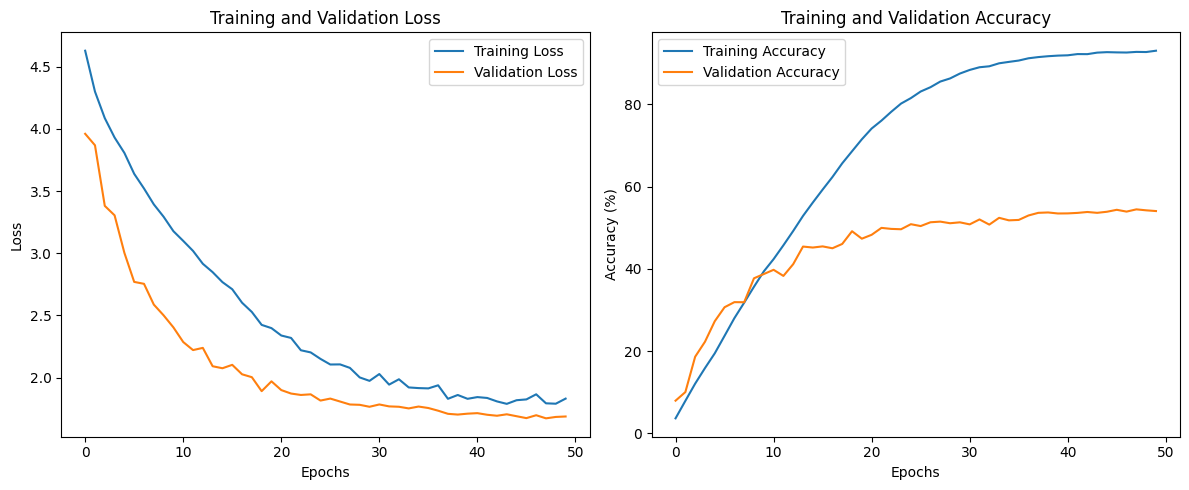

In [27]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Loading Best Model and Evaluate Performance

In [28]:
# Load the best model
model.load_state_dict(torch.load('/kaggle/input/scratch-cnn-tsinghua-dog-breed-detection/best_dog_breed_model.pth'))

# EVALUATION FUNCTIONS
def evaluate_model(model, test_loader, num_classes, class_names):
    """Evaluate the model and return metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {overall_accuracy:.2f}%')
    
    # Calculate per-class accuracy
    class_accuracy = [(i, 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0) 
                    for i in range(num_classes)]
    sorted_accuracy = sorted(class_accuracy, key=lambda x: x[1], reverse=True)
    
    print("\nTop 5 classes:")
    for i, acc in sorted_accuracy[:5]:
        print(f'Class {i} ({class_names[i]}): {acc:.2f}%')
    
    print("\nBottom 5 classes:")
    for i, acc in sorted_accuracy[-5:]:
        print(f'Class {i} ({class_names[i]}): {acc:.2f}%')
    
    return all_preds, all_labels, overall_accuracy, class_accuracy

/tmp/ipykernel_31/3847847796.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/scratch-cnn-tsinghua-dog-breed-detection/bes

In [29]:
### Evaluate the Model on Test Set

In [30]:
# Evaluate the model immediately
all_preds, all_labels, overall_accuracy, class_accuracy = evaluate_model(
    model, val_loader, num_classes, full_dataset.classes
)

Evaluating: 100%|██████████| 441/441 [00:41<00:00, 10.66it/s]

Accuracy on the test set: 83.74%

Top 5 classes:
Class 35 (vizsla): 100.00%
Class 54 (Norwegian_elkhound): 97.67%
Class 117 (komondor): 96.83%
Class 125 (golden_retriever): 96.22%
Class 81 (Boston_bull): 96.08%

Bottom 5 classes:
Class 12 (Staffordshire_bullterrier): 38.30%
Class 76 (collie): 36.36%
Class 116 (standard_poodle): 21.82%
Class 114 (toy_poodle): 8.88%
Class 105 (Japanese_Spitzes): 1.67%


### Plot Confusion Matrix for Top 20 Classes

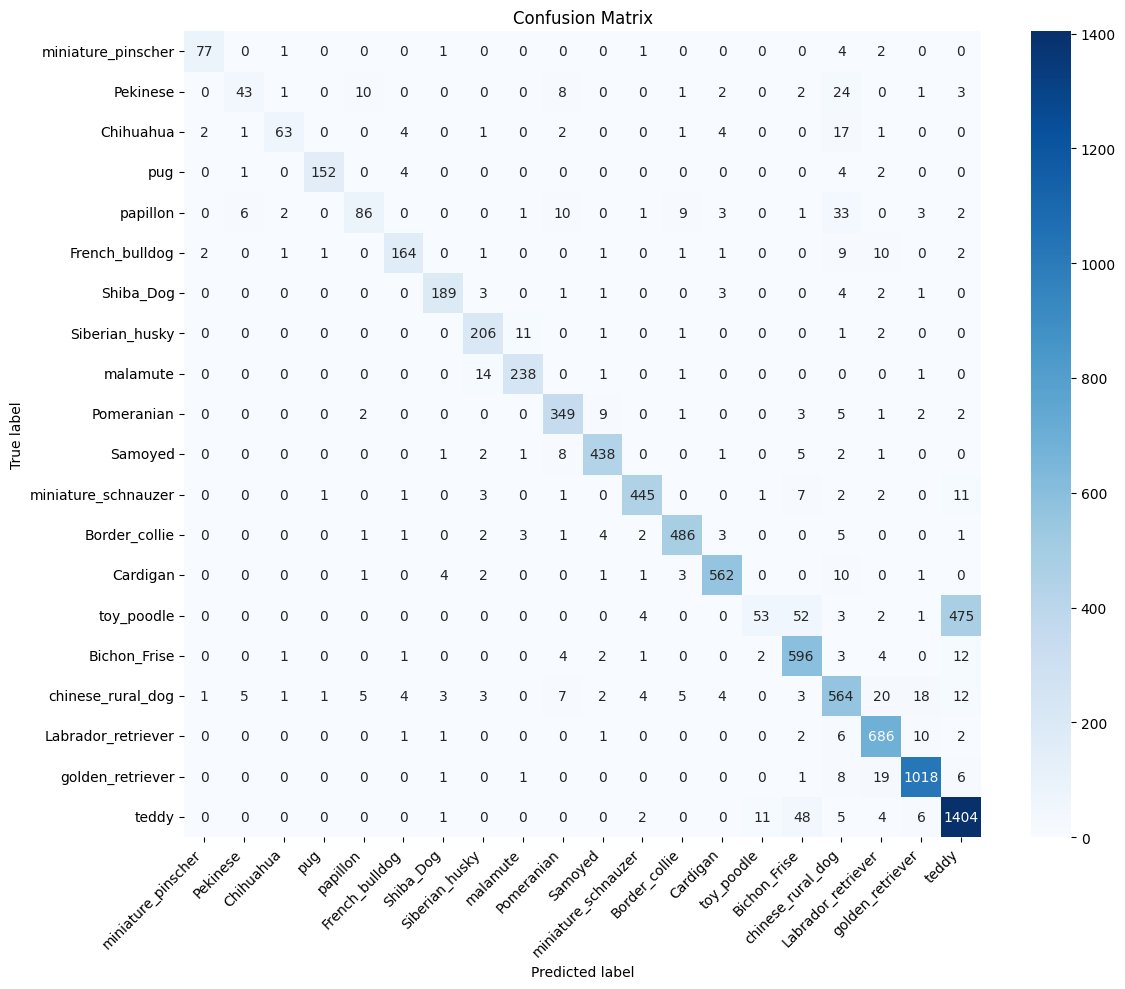

In [33]:
def plot_confusion_matrix(y_true, y_pred, class_names, max_classes=20):
    """Plot confusion matrix for model predictions"""
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # If there are many classes, select the top classes with most samples
    if len(class_names) > max_classes:
        # Sum samples per class
        class_counts = np.sum(cm, axis=1)
        # Get indices of top classes
        top_classes_idx = np.argsort(class_counts)[-max_classes:]
        # Filter confusion matrix to include only top classes
        cm = cm[top_classes_idx][:, top_classes_idx]
        # Filter class names
        plot_class_names = [class_names[i] for i in top_classes_idx]
    else:
        plot_class_names = class_names
    
    # Set up the figure
    plt.figure(figsize=(12, 10))
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=plot_class_names, 
                yticklabels=plot_class_names)
    
    plt.title('Confusion Matrix (Classes with Most Samples)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot confusion matrix immediately
plot_confusion_matrix(all_labels, all_preds, full_dataset.classes)

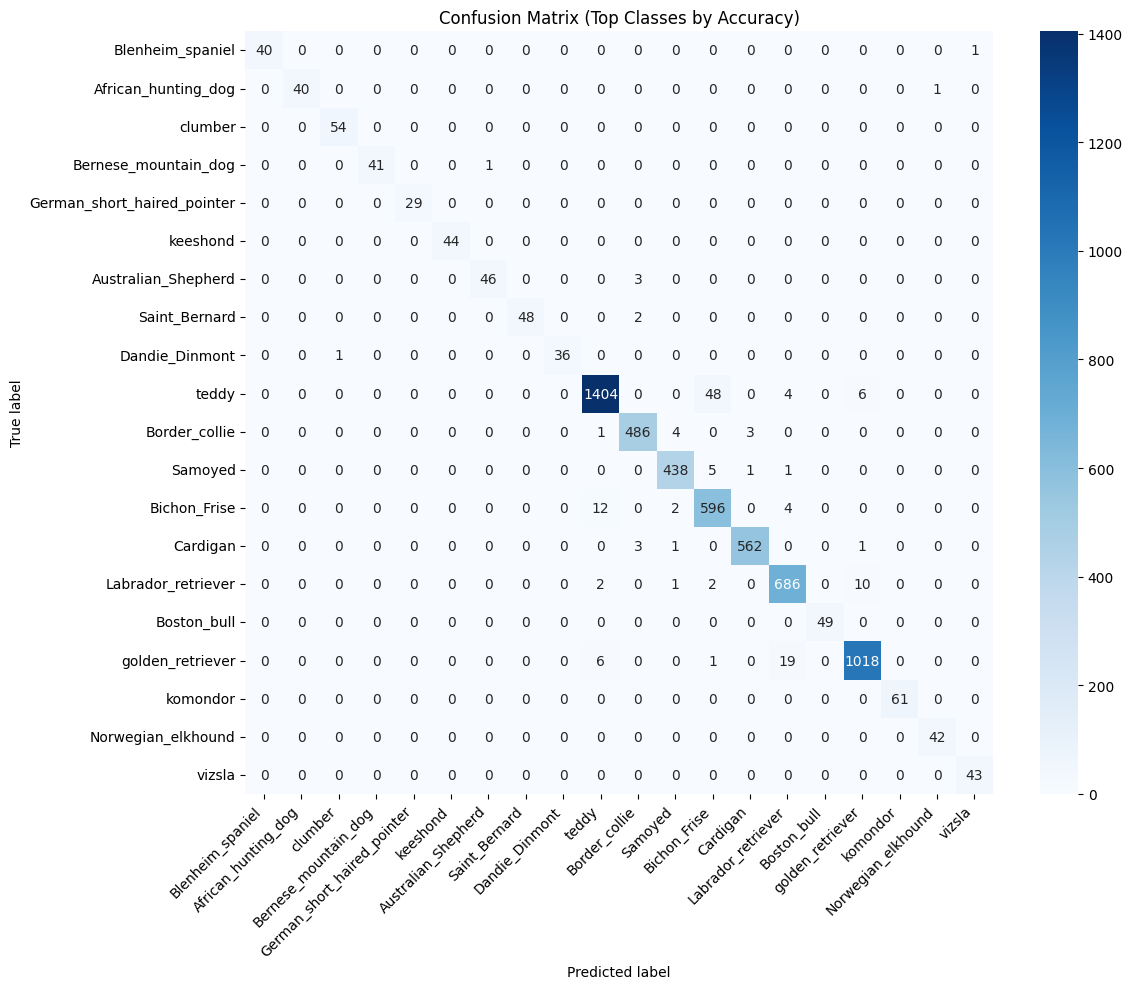

In [36]:
def plot_confusion_matrix(y_true, y_pred, class_names, max_classes=20):
    """Plot confusion matrix for model predictions, prioritizing classes by highest accuracy"""
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # If there are many classes, select classes based on highest accuracy
    if len(class_names) > max_classes:
        # Calculate per-class accuracy
        class_accuracy = np.zeros(len(class_names))
        class_samples = np.sum(cm, axis=1)  # Total samples per class
        
        for i in range(len(class_names)):
            if class_samples[i] > 0:  # Avoid division by zero
                class_accuracy[i] = cm[i, i] / class_samples[i]
            else:
                class_accuracy[i] = 0
                
        # Get indices of top classes by accuracy
        top_classes_idx = np.argsort(class_accuracy)[-max_classes:]
        
        # Filter confusion matrix to include only top classes
        cm = cm[top_classes_idx][:, top_classes_idx]
        # Filter class names
        plot_class_names = [class_names[i] for i in top_classes_idx]
    else:
        plot_class_names = class_names
    
    # Set up the figure
    plt.figure(figsize=(12, 10))
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=plot_class_names, 
                yticklabels=plot_class_names)
    
    plt.title('Confusion Matrix (Top Classes by Accuracy)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix_top_accuracy.png')
    plt.show()

# Plot confusion matrix immediately
plot_confusion_matrix(all_labels, all_preds, full_dataset.classes)